In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **LIBRARIES**

In [ ]:
import tensorflow as tf
import numpy as np
from numpy import asarray
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
import datetime
import pathlib

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.17.1


In [ ]:
seed = 42127
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['TF_XLA_FLAGS'] = '--tf_xla_auto_jit=0'
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

### Suppress warnings

In [ ]:
import warnings
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# **Dataset**




In [ ]:
from tensorflow.keras.utils import to_categorical
dataset_path_train = '/content/drive/MyDrive/Homework1/dataset/npz_NoTestSet/filtered_classes_noOutliears/train_set_StrongAugmentation_Balanced/train_set_Unified.npz'
dataset_path_val = '/content/drive/MyDrive/Homework1/dataset/npz_NoTestSet/filtered_classes_noOutliears/val_set.npz'

data = np.load(dataset_path_train)
X_train = data['images']
y_train_flatten = data['labels'].flatten()
y_train = to_categorical(y_train_flatten, num_classes=8)

data = np.load(dataset_path_val)
X_val = data['images']
y_val_flatten = data['labels'].flatten()
y_val = to_categorical(y_val_flatten, num_classes=8)


In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(factor=0.2, fill_mode='reflect'),
    tf.keras.layers.RandomZoom(height_factor=0.3, width_factor=0.3, fill_mode='reflect'),
    tf.keras.layers.RandomTranslation(height_factor=(-0.3, 0.3), width_factor=(-0.3, 0.3), fill_mode='reflect'),  # Added translation
], name='data_augmentation')

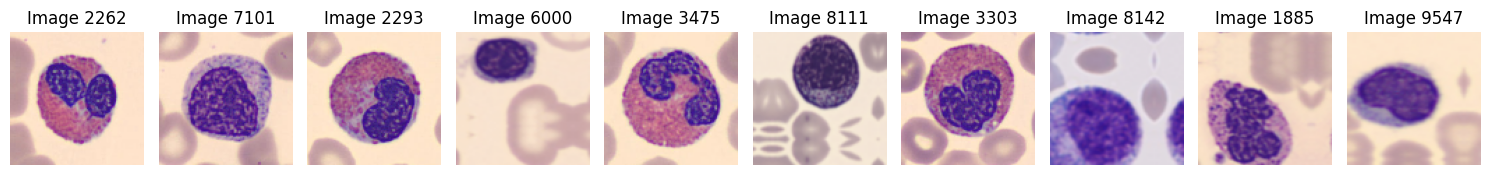

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_random_images(X_train, num_images=10):
    """
    Plots a random selection of images from the dataset.

    Parameters:
        X_train (numpy array): Array of images, shape (num_samples, height, width, channels)
                               or (num_samples, height, width) for grayscale.
        num_images (int): Number of random images to plot.
    """
    # Ensure X_train is a numpy array
    X_train = np.array(X_train)

    # Randomly select indices
    random_indices = np.random.choice(len(X_train), size=num_images, replace=False)
    selected_images = X_train[random_indices]

    # Plot the images
    fig, axes = plt.subplots(1, num_images, figsize=(15, 15))
    for i, ax in enumerate(axes):
        if selected_images[i].ndim == 2:  # Grayscale images
            ax.imshow(selected_images[i], cmap='gray')
        else:  # RGB or other formats
            ax.imshow(selected_images[i])
        ax.axis('off')
        ax.set_title(f"Image {random_indices[i]}")

    plt.tight_layout()
    plt.show()

# Example usage
# Assuming X_train is your dataset
# X_train = data['images']  # Replace this with your actual dataset
plot_random_images(X_train)

# **Transfer Learning**

In [ ]:
initial_time = datetime.datetime.now()
input_shape = (96, 96, 3)
epochs = 50

In [ ]:
supernet = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet', input_shape=(128,128,3))
supernet.trainable = False

for i, layer in enumerate(convnext_submodel.layers[-20:]):
  if not isinstance(layer, tf.keras.layers.BatchNormalization):
    layer.trainable = True

X_train = tf.keras.applications.vgg19.preprocess_input(X_train)
X_val = tf.keras.applications.vgg19.preprocess_input(X_val)

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
#ARCHITECTURE
input_layer = tfkl.Input(input_shape)

x = tfkl.Resizing(height = 128, width = 128, interpolation = 'bilinear' )(input_layer)
x = data_augmentation(x)
x = supernet(x)
x = tfkl.GlobalAveragePooling2D()(x)
x = tfkl.Dropout(rate=0.3)(x)
x = tfkl.Dense(units=128, name='Dense3', kernel_initializer=tfk.initializers.HeUniform(seed),  activation='relu')(x)
x = tfkl.Dropout(rate=0.3)(x)
output_layer = tfkl.Dense(units=8, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='output_layer')(x)

model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(1e-4), metrics=['accuracy'])

In [ ]:
from datetime import datetime
def create_folders_and_callbacks(model_name):

    callbacks = []

    # Early Stopping
    # --------------
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)
    callbacks.append(es_callback)
    return callbacks

###Class Weight

In [ ]:
from sklearn.utils import class_weight
import tensorflow as tf

# Compute class weights based on y_train_flatten
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_flatten),
    y=y_train_flatten
)

# Convert to dictionary format
class_weights_dict = dict(enumerate(class_weights))

# Print the computed class weights
print(class_weights_dict)

{0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0}


In [ ]:
model.summary()

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resizing (Resizing)                  │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ data_augmentation (Sequential)       │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg19 (Functional)                   │ (None, 4, 4, 512)           │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense3 (Dense)                       │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,091,080 (76.64 MB)

 Trainable params: 66,696 (260.53 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

**We have all the layers of VGG19 non trainable, because we want to do Transfer Learning**

In [ ]:
for i, layer in enumerate(model.get_layer('vgg19').layers):
   print(i, layer.name, layer.trainable)

0 input_layer False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_conv4 False
11 block3_pool False
12 block4_conv1 False
13 block4_conv2 False
14 block4_conv3 False
15 block4_conv4 False
16 block4_pool False
17 block5_conv1 False
18 block5_conv2 False
19 block5_conv3 False
20 block5_conv4 False
21 block5_pool False


###Training

In [ ]:
callbacks = create_folders_and_callbacks(model_name='myModel')

history = model.fit(
    x=X_train,
    y=y_train,
    epochs = epochs,
    validation_data = (X_val, y_val),
    callbacks = callbacks,
).history

Epoch 1/50
510/510 ━━━━━━━━━━━━━━━━━━━━ 47s 75ms/step - accuracy: 0.1679 - loss: 6.1918 - val_accuracy: 0.3475 - val_loss: 1.8531
Epoch 2/50
510/510 ━━━━━━━━━━━━━━━━━━━━ 36s 71ms/step - accuracy: 0.2870 - loss: 2.5595 - val_accuracy: 0.3823 - val_loss: 1.6233
Epoch 3/50
510/510 ━━━━━━━━━━━━━━━━━━━━ 40s 69ms/step - accuracy: 0.3365 - loss: 1.9246 - val_accuracy: 0.4162 - val_loss: 1.5297
Epoch 4/50
510/510 ━━━━━━━━━━━━━━━━━━━━ 36s 70ms/step - accuracy: 0.3798 - loss: 1.7109 - val_accuracy: 0.4549 - val_loss: 1.4130
Epoch 5/50
510/510 ━━━━━━━━━━━━━━━━━━━━ 41s 70ms/step - accuracy: 0.4214 - loss: 1.5746 - val_accuracy: 0.4768 - val_loss: 1.3314
Epoch 6/50
510/510 ━━━━━━━━━━━━━━━━━━━━ 41s 70ms/step - accuracy: 0.4432 - loss: 1.5113 - val_accuracy: 0.5133 - val_loss: 1.2616
Epoch 7/50
510/510 ━━━━━━━━━━━━━━━━━━━━ 41s 70ms/step - accuracy: 0.4714 - loss: 1.4193 - val_accuracy: 0.5408 - val_loss: 1.1674
Epoch 8/50
510/510 ━━━━━━━━━━━━━━━━━━━━ 41s 70ms/step - accuracy: 0.5050 - loss: 1.3408 - 

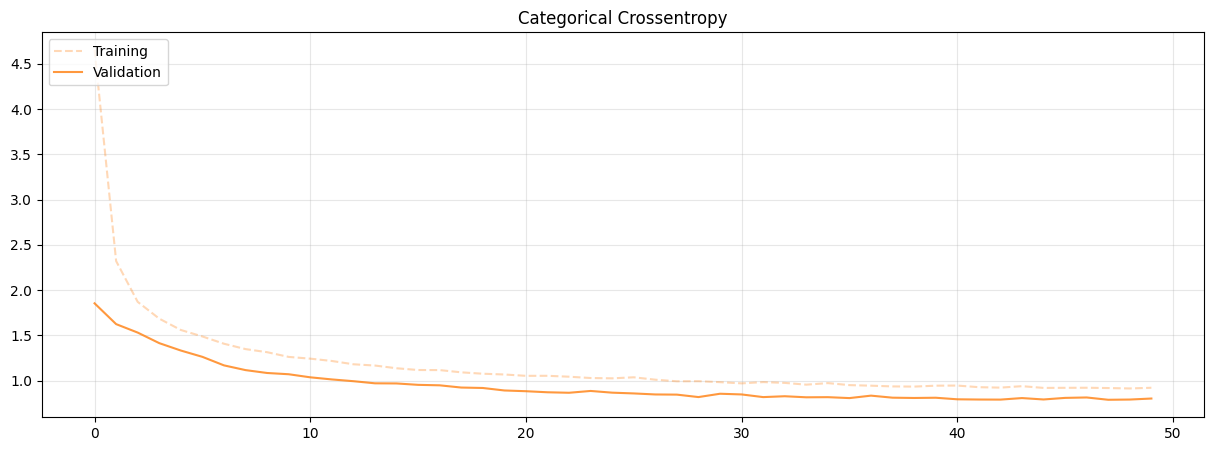

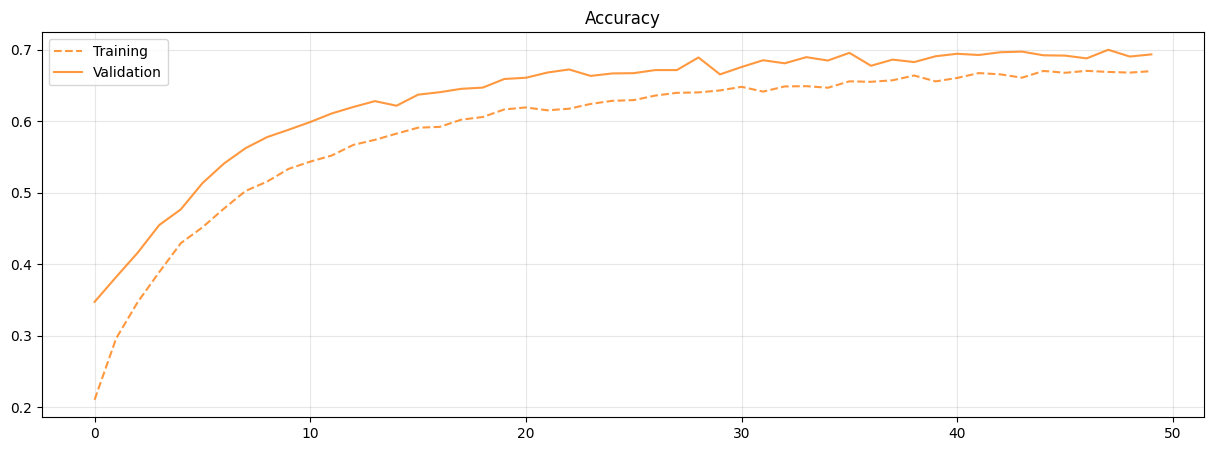

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(history['loss'], label='Training', alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='Validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:

output_dir = '/content/drive/My Drive/Homework1/net_output'  # Directory to save logs, plots, and models


# Save the trained model with the final accuracy in the filename
model_filename = f'{output_dir}/VGG19_withClassWeight_withStrongBalancedDataset_withTrainAugmentation.keras'
model.save(model_filename)
print(f"Model saved at {model_filename}")

Model saved at /content/drive/My Drive/Homework1/net_output/VGG19_withClassWeight_withStrongBalancedDataset_withTrainAugmentation.keras


# **Fine Tuning**

**IMPORT MODEL**

In [ ]:
output_dir = '/content/drive/My Drive/Homework1/net_output'  # Directory to save logs, plots, and models

# Save the trained model with the final accuracy in the filename
model_filename = f'{output_dir}/VGG19_withClassWeight_withStrongBalancedDataset_withTrainAugmentation.keras'

model = tf.keras.models.load_model(model_filename)

vgg19_submodel = model.get_layer('vgg19')  # Make sure this is the correct name

# Set all layers in VGG19 to be trainable
vgg19_submodel.trainable = False

# Unfreeze the last few layers in VGG19
for i, layer in enumerate(vgg19_submodel.layers[-14:]):
  if not isinstance(layer, tf.keras.layers.BatchNormalization):
    layer.trainable = True

# Verify trainable layers
for i, layer in enumerate(vgg19_submodel.layers):
    print(f"Layer {i}: {layer.name} - Trainable: {layer.trainable}")

Layer 0: input_layer - Trainable: True
Layer 1: block1_conv1 - Trainable: False
Layer 2: block1_conv2 - Trainable: False
Layer 3: block1_pool - Trainable: False
Layer 4: block2_conv1 - Trainable: False
Layer 5: block2_conv2 - Trainable: False
Layer 6: block2_pool - Trainable: False
Layer 7: block3_conv1 - Trainable: False
Layer 8: block3_conv2 - Trainable: True
Layer 9: block3_conv3 - Trainable: True
Layer 10: block3_conv4 - Trainable: True
Layer 11: block3_pool - Trainable: True
Layer 12: block4_conv1 - Trainable: True
Layer 13: block4_conv2 - Trainable: True
Layer 14: block4_conv3 - Trainable: True
Layer 15: block4_conv4 - Trainable: True
Layer 16: block4_pool - Trainable: True
Layer 17: block5_conv1 - Trainable: True
Layer 18: block5_conv2 - Trainable: True
Layer 19: block5_conv3 - Trainable: True
Layer 20: block5_conv4 - Trainable: True
Layer 21: block5_pool - Trainable: True


**USE MODEL (inside RAM)**

In [ ]:
for i, layer in enumerate(model.get_layer('vgg19').layers):
   print(i, layer.name, layer.trainable)

0 input_layer True
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_conv4 False
11 block3_pool False
12 block4_conv1 False
13 block4_conv2 False
14 block4_conv3 True
15 block4_conv4 True
16 block4_pool True
17 block5_conv1 True
18 block5_conv2 True
19 block5_conv3 True
20 block5_conv4 True
21 block5_pool True


In [ ]:
# Compile the model
model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-5), metrics=['accuracy'])

model.summary()

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resizing (Resizing)                  │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ data_augmentation (Sequential)       │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg19 (Functional)                   │ (None, 4, 4, 512)           │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense3 (Dense)                       │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,091,080 (76.64 MB)

 Trainable params: 19,535,752 (74.52 MB)

 Non-trainable params: 555,328 (2.12 MB)

In [ ]:
callbacks = create_folders_and_callbacks(model_name='myModel')
epochs = 5

class_weight_dict = {
    0: 1.0,  # Default weight for class 0
    1: 1.0,  # Default weight for class 1
    2: 1.0,  # Default weight for class 2
    3: 0.7,  # Default weight for class 3
    4: 1.0,  # Default weight for class 4
    5: 2.0,  # Higher weight for class 5
    6: 1.0,  # Default weight for class 6
    7: 1.0   # Default weight for class 7
}

history = model.fit(
    x=X_train,
    y=y_train,
    epochs = epochs,
    validation_data = (X_val, y_val),
    callbacks = callbacks,
    class_weight=class_weight_dict
).history

Epoch 1/5
510/510 ━━━━━━━━━━━━━━━━━━━━ 85s 156ms/step - accuracy: 0.6953 - loss: 0.9224 - val_accuracy: 0.9313 - val_loss: 0.2233
Epoch 2/5
510/510 ━━━━━━━━━━━━━━━━━━━━ 80s 154ms/step - accuracy: 0.8943 - loss: 0.3405 - val_accuracy: 0.9454 - val_loss: 0.2036
Epoch 3/5
510/510 ━━━━━━━━━━━━━━━━━━━━ 82s 154ms/step - accuracy: 0.9247 - loss: 0.2484 - val_accuracy: 0.9579 - val_loss: 0.1517
Epoch 4/5
510/510 ━━━━━━━━━━━━━━━━━━━━ 78s 153ms/step - accuracy: 0.9394 - loss: 0.2054 - val_accuracy: 0.9656 - val_loss: 0.1096
Epoch 5/5
510/510 ━━━━━━━━━━━━━━━━━━━━ 78s 153ms/step - accuracy: 0.9486 - loss: 0.1672 - val_accuracy: 0.9734 - val_loss: 0.0957
